# Goal : To predict Diabetes using only Apple watch data


In [124]:
import pandas as pd

df = pd.read_csv("Data/diabetes_prediction_dataset.csv")

# drop columns Apple Watch can never replicate
df = df.drop(columns=["smoking_history"])

In [125]:
print(df["diabetes"].value_counts(normalize=True))

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [126]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["gender"] = le.fit_transform(df["gender"])

X = df.drop(columns=["diabetes"])
y = df["diabetes"]

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [128]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

model_clinical = XGBClassifier(
    max_depth=5,
    n_estimators=250,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=8,
    eval_metric="logloss"
)

model_clinical.fit(X_train, y_train)

y_pred = model_clinical.predict(X_test)
y_prob = model_clinical.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.92275
AUC: 0.9793635165541626


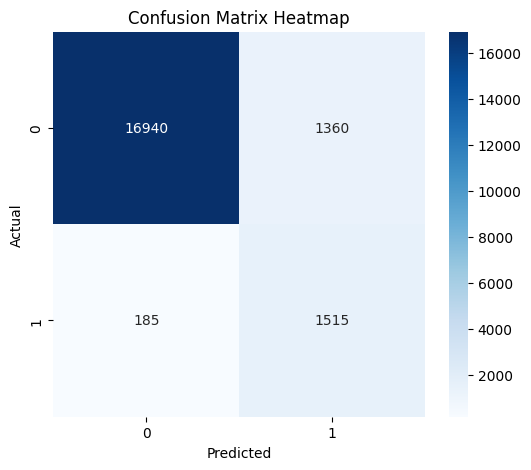

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_clinical.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [130]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     18300
           1       0.53      0.89      0.66      1700

    accuracy                           0.92     20000
   macro avg       0.76      0.91      0.81     20000
weighted avg       0.95      0.92      0.93     20000



In [131]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_prob = model_clinical.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.10, 0.90, 0.02)

print("t      precision   recall   f1")
for t in thresholds:
    preds = (y_prob > t).astype(int)
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{t:.2f}    {p:.3f}       {r:.3f}    {f1:.3f}")

t      precision   recall   f1
0.10    0.279       0.993    0.436
0.12    0.294       0.988    0.453
0.14    0.305       0.986    0.466
0.16    0.318       0.986    0.481
0.18    0.328       0.984    0.492
0.20    0.339       0.980    0.503
0.22    0.350       0.975    0.515
0.24    0.360       0.972    0.525
0.26    0.373       0.967    0.538
0.28    0.383       0.962    0.548
0.30    0.392       0.958    0.556
0.32    0.401       0.952    0.564
0.34    0.411       0.948    0.574
0.36    0.422       0.946    0.583
0.38    0.432       0.942    0.592
0.40    0.442       0.934    0.600
0.42    0.456       0.928    0.612
0.44    0.472       0.921    0.624
0.46    0.490       0.911    0.637
0.48    0.511       0.903    0.653
0.50    0.527       0.891    0.662
0.52    0.549       0.884    0.677
0.54    0.574       0.871    0.692
0.56    0.599       0.861    0.706
0.58    0.624       0.849    0.719
0.60    0.643       0.838    0.728
0.62    0.658       0.830    0.734
0.64    0.683       0.82

In [132]:
THRESHOLD = 0.82

def predict_diabetes_thresholded(model, X_row, threshold=THRESHOLD):
    y_prob = model.predict_proba([X_row])[0][1]
    return int(y_prob >= threshold), y_prob

In [133]:
y_prob = model_clinical.predict_proba(X_test)[:,1]
y_pred_084 = (y_prob >= 0.82).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_084))
print(classification_report(y_test, y_pred_084))

[[18218    82]
 [  489  1211]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.71      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000



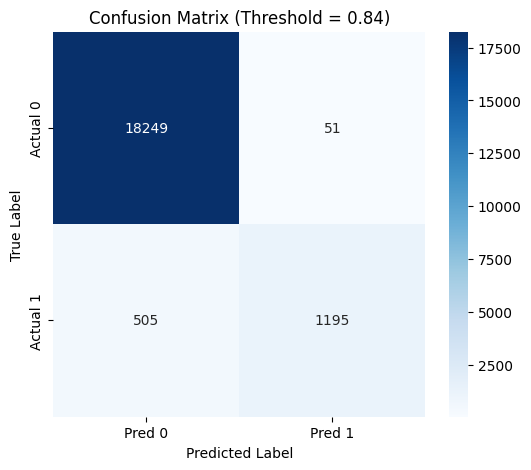

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# thresholded predictions
y_prob = model_clinical.predict_proba(X_test)[:,1]
y_pred_084 = (y_prob >= 0.84).astype(int)

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_084)

# plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix (Threshold = 0.84)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

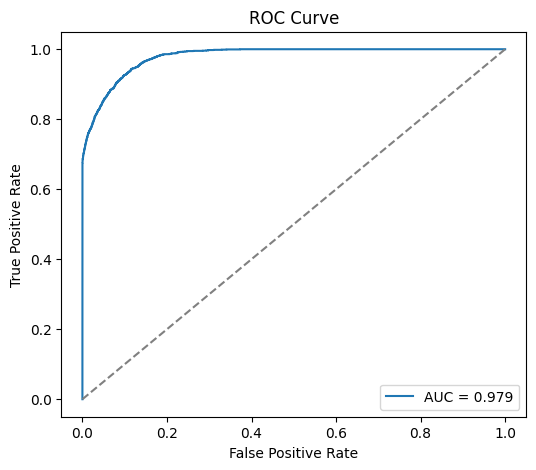

In [135]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model_clinical.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

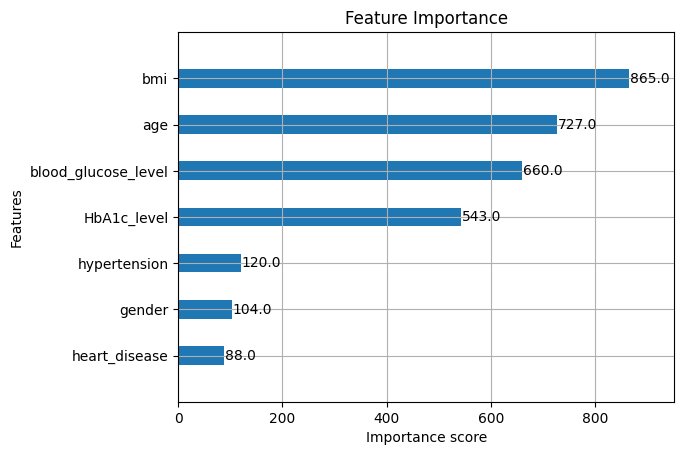

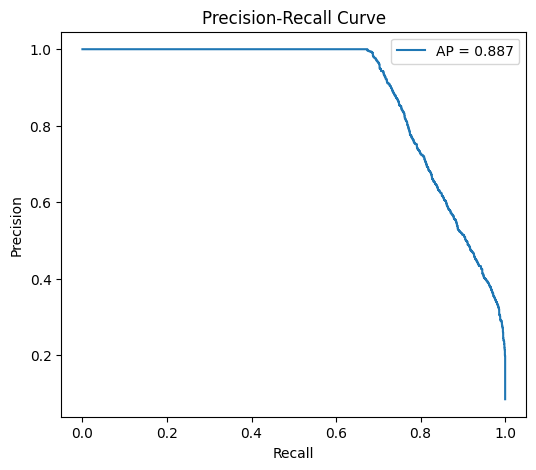

In [136]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model_clinical, height=0.4, max_num_features=10)
plt.title("Feature Importance")
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Predict through apple watch data now

In [148]:
folder_path = "Patients_90days"

In [161]:
import os
import pandas as pd
import numpy as np

DATA_DIR = "Patients_90days"

all_rows = []

for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue
    
    fpath = os.path.join(DATA_DIR, fname)
    df_p = pd.read_csv(fpath)

    # Ensure required column exists
    if "date" not in df_p.columns:
        print(f"[WARN] Skipping {fname}: missing 'date'")
        continue

    # Make date consistent
    df_p["date"] = pd.to_datetime(df_p["date"]).dt.date

    # Label from filename: *_d.csv → diabetic
    diabetes_label = 1 if fname.lower().endswith("_d.csv") else 0
    df_p["diabetes"] = diabetes_label

    # Add patient ID (string)
    df_p["patient_id"] = fname.replace(".csv","")

    all_rows.append(df_p)

# Combine all patients into one DataFrame
df_all = pd.concat(all_rows, ignore_index=True)

print("TOTAL ROWS:", df_all.shape)
print("TOTAL PATIENTS:", df_all['patient_id'].nunique())

# Preview
df_all.head()

TOTAL ROWS: (24300, 32)
TOTAL PATIENTS: 270


,date,heart_rate_mean,heart_rate_min,heart_rate_max,heart_rate_std,hrv_mean,hrv_min,hrv_max,hrv_std,steps_sum,...,exercise_minutes_sum,stand_minutes_sum,sleeping_wrist_temp_degF_mean,sleep_minutes_sum,age_years,sex_encoded,weight_kg,bmi,diabetes,patient_id
0,2024-01-01,57.373765,51.106741,77.540326,10.351927,66.672152,25.740745,98.869462,17.531832,11339.674464,...,59.743150,43.619355,96.546846,0.604524,48.474877,1.0,97.777649,29.686617,0,patient_213
1,2024-01-02,67.423033,56.681102,80.840105,10.759716,93.016605,77.916901,112.431903,19.151989,11731.570460,...,46.634195,60.952592,96.473779,0.385892,48.474877,1.0,97.777649,29.686617,0,patient_213
2,2024-01-03,66.356165,52.331397,81.043633,8.054568,127.123104,82.178557,149.926778,27.792282,7099.501660,...,28.204885,50.879298,96.210039,0.780251,48.474877,1.0,97.777649,29.686617,0,patient_213
3,2024-01-04,73.407163,61.622877,85.819336,7.559893,122.493047,111.360042,157.619123,10.298008,11345.352575,...,49.011871,40.314989,96.426169,0.501214,48.474877,1.0,97.777649,29.686617,0,patient_213
4,2024-01-05,72.040932,59.698142,87.278672,8.541667,107.640043,70.482948,125.318417,8.735668,8180.103828,...,27.166692,41.455860,97.054599,0.641987,48.474877,1.0,97.777649,29.686617,0,patient_213


In [162]:
import pandas as pd

# Load real daily Apple Watch file
real_daily = pd.read_csv("Data/apple_watch_daily_features.csv")

# Rename columns in real daily file to match training data style
rename_map_real = {
    "active_energy_kcal_sum": "active_energy_cal_sum",
    "basal_energy_kcal_sum": "basal_energy_cal_sum",
    "wrist_temp_degC_mean": "sleeping_wrist_temp_degF_mean",

    "weight_kg_mean": "weight_kg",
    "bmi_mean": "bmi",
    "age_years_mean": "age_years",
    "sex_encoded_first": "sex_encoded"
}

real_daily = real_daily.rename(columns=rename_map_real)
real_cols = set(real_daily.columns)
train_cols = set(df_all.columns)

# Full candidate feature list
candidate_features = [
    "heart_rate_mean", "heart_rate_min", "heart_rate_max", "heart_rate_std",
    "hrv_mean", "hrv_min", "hrv_max", "hrv_std",
    "steps_sum", "steps_max",
    "resting_hr_mean",
    "vo2max_mean",
    "respiratory_rate_mean", "respiratory_rate_min", "respiratory_rate_max",
    "spo2_percent_mean", "spo2_percent_min",
    "active_energy_cal_sum",
    "basal_energy_cal_sum",
    "distance_walk_run_m_sum",
    "flights_sum",
    "exercise_minutes_sum",
    "stand_minutes_sum",
    "sleeping_wrist_temp_degF_mean",
    "sleep_minutes_sum",
    "age_years", "sex_encoded", "weight_kg", "bmi"
]

# Keep only features that exist in BOTH datasets
feature_cols = [
    c for c in candidate_features
    if (c in train_cols) and (c in real_cols)
]

print("FINAL FEATURES USED FOR TRAINING & REAL PREDICTION:")
print(feature_cols)
print("\nTotal features:", len(feature_cols))

FINAL FEATURES USED FOR TRAINING & REAL PREDICTION:
['heart_rate_mean', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'hrv_mean', 'hrv_min', 'hrv_max', 'hrv_std', 'steps_sum', 'steps_max', 'resting_hr_mean', 'vo2max_mean', 'respiratory_rate_mean', 'respiratory_rate_min', 'respiratory_rate_max', 'spo2_percent_mean', 'spo2_percent_min', 'distance_walk_run_m_sum', 'flights_sum', 'exercise_minutes_sum', 'stand_minutes_sum', 'sleep_minutes_sum', 'age_years', 'sex_encoded', 'weight_kg', 'bmi']

Total features: 26


In [170]:
from sklearn.model_selection import train_test_split

# Unique patients
patients = df_all["patient_id"].unique()

# Get one diabetes label per patient (assume constant within a file)
patient_labels = []
for pid in patients:
    sub = df_all[df_all["patient_id"] == pid]
    lbl = int(sub["diabetes"].iloc[0])
    patient_labels.append(lbl)

# Patient-level train/test split (NO leakage)
train_ids, test_ids = train_test_split(
    patients,
    test_size=0.2,
    stratify=patient_labels,
    random_state=42
)

# Build train/test DataFrames
train_df = df_all[df_all["patient_id"].isin(train_ids)].copy()
test_df  = df_all[df_all["patient_id"].isin(test_ids)].copy()

# Use the aligned feature_cols from Block 2
X_train = train_df[feature_cols]
y_train = train_df["diabetes"].astype(int)

train_medians = X_train.median()

X_test  = test_df[feature_cols]
y_test  = test_df["diabetes"].astype(int)

print("Train patients:", len(train_ids))
print("Test patients:", len(test_ids))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train patients: 216
Test patients: 54
Train shape: (19440, 26) Test shape: (4860, 26)


In [171]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np

# ---- Train model on synthetic patients using aligned feature_cols ----
model_watch = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

model_watch.fit(X_train, y_train)

# ---- Evaluate on patient-level test set ----
y_prob = model_watch.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

AUC: 0.9051319359652693
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2520
           1       0.83      0.84      0.84      2340

    accuracy                           0.84      4860
   macro avg       0.84      0.84      0.84      4860
weighted avg       0.84      0.84      0.84      4860

Confusion matrix:
 [[2127  393]
 [ 365 1975]]


In [172]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.91, 0.02)
best_t = None
best_f1 = -1

print("t      precision   recall   f1")
for t in thresholds:
    preds_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, preds_t)
    r = recall_score(y_test, preds_t)
    f1 = f1_score(y_test, preds_t)
    print(f"{t:.2f}    {p:.3f}       {r:.3f}    {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("\nBest threshold by F1:", best_t, "with F1:", best_f1)

t      precision   recall   f1
0.10    0.782       0.851    0.815
0.12    0.788       0.849    0.817
0.14    0.792       0.848    0.819
0.16    0.796       0.848    0.821
0.18    0.800       0.847    0.823
0.20    0.805       0.847    0.826
0.22    0.810       0.847    0.828
0.24    0.813       0.847    0.829
0.26    0.816       0.846    0.831
0.28    0.819       0.846    0.832
0.30    0.820       0.846    0.833
0.32    0.822       0.846    0.834
0.34    0.825       0.846    0.835
0.36    0.827       0.846    0.836
0.38    0.828       0.846    0.837
0.40    0.829       0.846    0.838
0.42    0.830       0.846    0.838
0.44    0.831       0.846    0.838
0.46    0.832       0.845    0.838
0.48    0.833       0.845    0.839
0.50    0.834       0.844    0.839
0.52    0.835       0.844    0.840
0.54    0.837       0.843    0.840
0.56    0.839       0.843    0.841
0.58    0.840       0.843    0.841
0.60    0.841       0.843    0.842
0.62    0.843       0.842    0.843
0.64    0.846       0.84

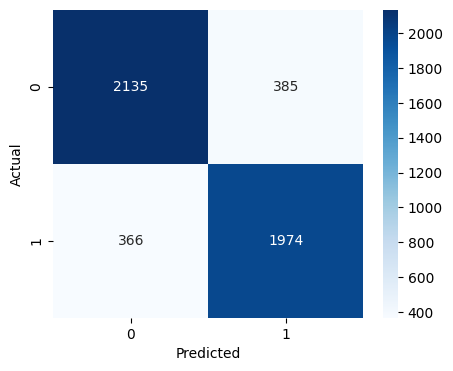

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [176]:
def predict_watch_user(csv_path, feature_cols=feature_cols, threshold=None):
    """
    Predict diabetes risk for a user from a daily Apple Watch feature CSV.
    Uses median imputation for missing values instead of dropping all rows.
    Returns (predicted_label, mean_probability, per_day_probabilities).
    """

    # Use tuned threshold if not passed explicitly
    if threshold is None:
        threshold = best_t if "best_t" in globals() else 0.5

    df = pd.read_csv(csv_path)

    # Rename aggregated columns from real daily file to match model feature names
    rename_map = {
        "weight_kg_mean": "weight_kg",
        "bmi_mean": "bmi",
        "age_years_mean": "age_years",
        "sex_encoded_first": "sex_encoded",
        # Add these only if your daily file has energy/temp columns later:
        # "active_energy_kcal_sum": "active_energy_cal_sum",
        # "basal_energy_kcal_sum": "basal_energy_cal_sum",
        # "wrist_temp_degC_mean": "sleeping_wrist_temp_degF_mean",
    }
    df = df.rename(columns=rename_map)

    # Check that required features exist
    missing_cols = [c for c in feature_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing features in input CSV: {missing_cols}")

    # Filter only the feature columns
    X_user = df[feature_cols].copy()

    # If an entire row is NaN across ALL features, drop it
    X_user = X_user.dropna(how="all")
    if X_user.empty:
        raise ValueError("All rows are completely NaN across all features.")

    # Fill remaining NaNs with training medians
    # (train_medians must be computed from X_train: train_medians = X_train.median())
    missing_in_medians = [c for c in feature_cols if c not in train_medians.index]
    if missing_in_medians:
        raise ValueError(f"train_medians missing columns: {missing_in_medians}")

    X_user = X_user.fillna(train_medians[feature_cols])

    # Now predict
    probs = model_watch.predict_proba(X_user)[:, 1]

    mean_prob = float(probs.mean())
    label = int(mean_prob >= threshold)

    return label, mean_prob, probs

In [177]:
label, mean_prob, daily_probs = predict_watch_user(
    "Data/apple_watch_daily_features.csv"
)

print("User-level diabetes probability:", mean_prob)
print("Predicted label (0 = non-diabetic, 1 = diabetic):", label)
print("First 10 daily probabilities:", daily_probs[:10])

User-level diabetes probability: 0.14857754111289978
Predicted label (0 = non-diabetic, 1 = diabetic): 0
First 10 daily probabilities: [0.15100679 0.1255028  0.13252151 0.08851855 0.13252151 0.08433973
 0.13620552 0.14132462 0.13768886 0.08552439]
